In [1]:
%pylab inline
import numpy as np

import sys
sys.path.append('../core/')
from Psi_generator import Psi_Generator
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
Psi_dict = np.load('../dense_Psi_predictions/Psi_32.npy',allow_pickle=True).item()
Psi_hat = Psi_dict['Psi']
t = Psi_dict['time']

In [3]:
t_POD = np.round(np.load('../../POD_files/t_POD.npy'),1)
Psi = np.load('../../POD_files/midEps_Psi.npy')[:,:32] 
Psi_std = np.std(Psi, axis=0)
Psi = Psi / Psi_std

mean_flow = np.load('../../POD_files/mean_flow.npy') 
Sigma = np.load('../../POD_files/midEps_Sigma.npy')[:32] 
Phi = np.load('../../POD_files/midEps_Phi.npy')[:,:32] 

In [4]:
data_path = '../../../Re_17500/'
X = np.vstack([np.load(data_path + 'Cx.npy'),np.load(data_path + 'Cy.npy')]).T
n = X.shape[0]
wing_boundary_x, wing_boundary_y = get_wing_boundary()

In [5]:
def reconstruct(psi):
    u_hat = mean_flow + Phi @ np.diag(Sigma) @ (psi.reshape(32,1) * Psi_std)
    return np.hstack([u_hat[:n], u_hat[n:]])

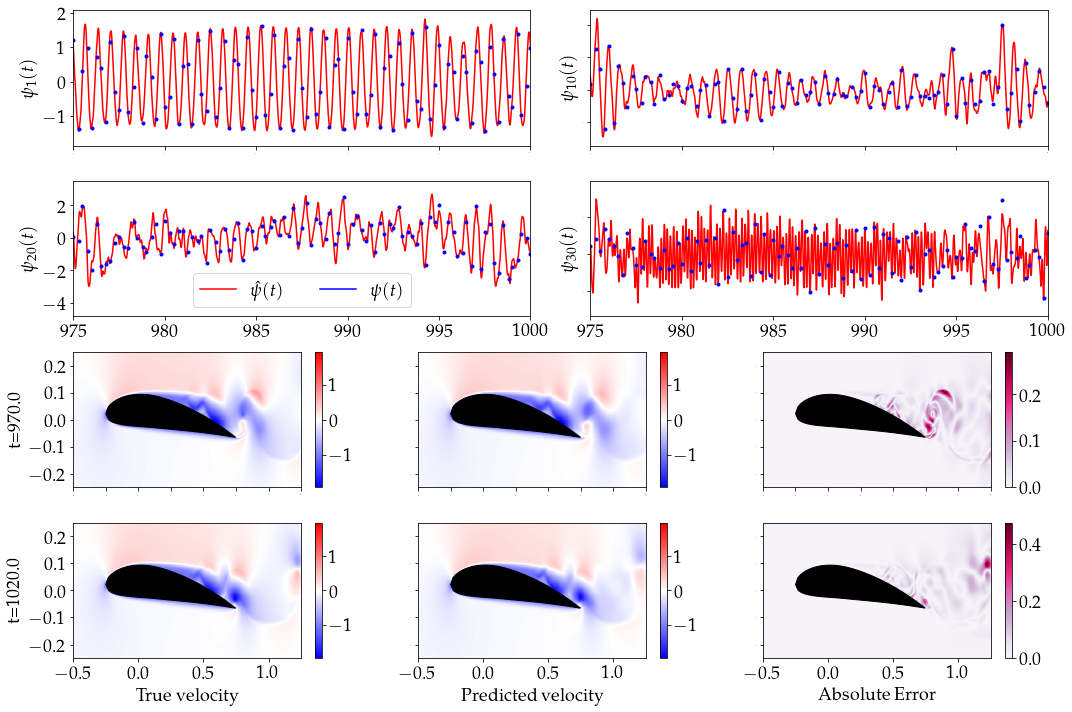

In [6]:
figure(figsize = (15,10))
label_fs = 18

tmin = 975
tmax = 1000

nx = 500
ny = 250

x = np.linspace(-0.5,1.25,nx)
y = np.linspace(-0.25,0.25,ny)
XX, YY = np.meshgrid(x, y)

snapshot_nums = [3800, 4000]
fine_snapshot_nums = [96793, 101793]
snapshot_times = t_POD[snapshot_nums]

rowspan_psi = 4
rowspan_u = 4
n_rows = 2*rowspan_psi + 2*rowspan_u

################################################################################
################################################################################
################################################################################

subplot2grid((n_rows,6),(0,0),rowspan=rowspan_psi,colspan=3)
ind = 0
plot(t,Psi_hat[:,ind], 'r')
plot(t_POD,Psi[:,ind], 'b.')
xlim([tmin,tmax])
ylabel(r'$\psi_{1}(t)$', fontsize = label_fs)
yticks(fontsize = label_fs)
xticks(fontsize = 0)

############################

subplot2grid((n_rows,6),(0,3),rowspan=rowspan_psi,colspan=3)
ind = 9
plot(t,Psi_hat[:,ind], 'r', label=r'$\hat{\psi}(t)$')
plot(t_POD,Psi[:,ind], 'b.', label=r'$\psi(t)$')
xlim([tmin,tmax])
ylabel(r'$\psi_{10}(t)$', fontsize = label_fs)
yticks(fontsize = 0)
xticks(fontsize = 0)

############################

subplot2grid((n_rows,6),(rowspan_psi,0),rowspan=rowspan_psi,colspan=3)
ind = 19
plot(t,Psi_hat[:,ind], 'r', label=r'$\hat{\psi}(t)$')
plot(t_POD,Psi[:,ind], 'b.')
plot([0,1],[0,0], 'b', label=r'$\psi(t)$')
xlim([tmin,tmax])
ylabel(r'$\psi_{20}(t)$', fontsize = label_fs)
# xlabel('Time', fontsize = label_fs)
yticks(fontsize = label_fs)
xticks(fontsize = label_fs)
legend(loc = 'lower center', fontsize = label_fs, ncol=2)

############################

subplot2grid((n_rows,6),(rowspan_psi,3),rowspan=rowspan_psi,colspan=3)
ind = 29
plot(t,Psi_hat[:,ind], 'r')
plot(t_POD,Psi[:,ind], 'b.')
xlim([tmin,tmax])
ylabel(r'$\psi_{30}(t)$', fontsize = label_fs)
# xlabel('Time', fontsize = label_fs)
yticks(fontsize = 0)
xticks(fontsize = label_fs)

################################################################################
################################################################################
################################################################################

u_hat = reconstruct(Psi_hat[fine_snapshot_nums[0],:])
u = np.load('../../../Re_17500/numpy_files/vel{0:05d}.npy'.format(snapshot_nums[0]+80))
u_grid = interp(u[:,0]-1, X[:,0], X[:,1], XX, YY, method='linear').reshape(ny,nx)
u_hat_grid = interp(u_hat[:,0]-1, X[:,0], X[:,1], XX, YY, method='linear').reshape(ny,nx)
max_abs = np.max(np.abs(np.stack([u_grid,u_hat_grid])))

subplot2grid((n_rows,6),(2*rowspan_psi,0),rowspan=rowspan_u,colspan=2)
pcolor(XX,YY,u_grid, cmap='bwr', vmin=-max_abs, vmax=max_abs, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = label_fs)
ylabel('t='+str(snapshot_times[0]), fontsize = label_fs)
# title('True velocity', fontsize = label_fs)
xticks(fontsize = 0)

subplot2grid((n_rows,6),(2*rowspan_psi,2),rowspan=rowspan_u,colspan=2)
pcolor(XX,YY,u_hat_grid, cmap='bwr', vmin=-max_abs, vmax=max_abs, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = 0)
xticks(fontsize = 0)
# title('Predicted velocity', fontsize = label_fs)

subplot2grid((n_rows,6),(2*rowspan_psi,4),rowspan=rowspan_u,colspan=2)
max_err = np.max(np.abs(u_grid-u_hat_grid))
pcolor(XX,YY,np.abs(u_grid-u_hat_grid), cmap='PuRd', vmin=0, vmax=max_err, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = 0)
# title('Absolute Error', fontsize = label_fs)
xticks(fontsize = 0)

############################

u_hat = reconstruct(Psi_hat[fine_snapshot_nums[1],:])
u = np.load('../../../Re_17500/numpy_files/vel{0:05d}.npy'.format(snapshot_nums[1]+80))
u_grid = interp(u[:,0]-1, X[:,0], X[:,1], XX, YY, method='linear').reshape(ny,nx)
u_hat_grid = interp(u_hat[:,0]-1, X[:,0], X[:,1], XX, YY, method='linear').reshape(ny,nx)
max_abs = np.max(np.abs(np.stack([u_grid,u_hat_grid])))

subplot2grid((n_rows,6),(2*rowspan_psi+rowspan_u,0),rowspan=rowspan_u,colspan=2)
pcolor(XX,YY,u_grid, cmap='bwr', vmin=-max_abs, vmax=max_abs, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = label_fs)
ylabel('t='+str(snapshot_times[1]), fontsize = label_fs)
xticks([-0.5,0,0.5,1], fontsize = label_fs)
xlabel('True velocity', fontsize = label_fs)

subplot2grid((n_rows,6),(2*rowspan_psi+rowspan_u,2),rowspan=rowspan_u,colspan=2)
pcolor(XX,YY,u_hat_grid, cmap='bwr', vmin=-max_abs, vmax=max_abs, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = 0)
xticks([-0.5,0,0.5,1], fontsize = label_fs)
xlabel('Predicted velocity', fontsize = label_fs)

subplot2grid((n_rows,6),(2*rowspan_psi+rowspan_u,4),rowspan=rowspan_u,colspan=2)
max_err = np.max(np.abs(u_grid-u_hat_grid))
pcolor(XX,YY,np.abs(u_grid-u_hat_grid), cmap='PuRd', vmin=0, vmax=max_err, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = 0)
xticks([-0.5,0,0.5,1], fontsize = label_fs)
xlabel('Absolute Error', fontsize = label_fs)

tight_layout()

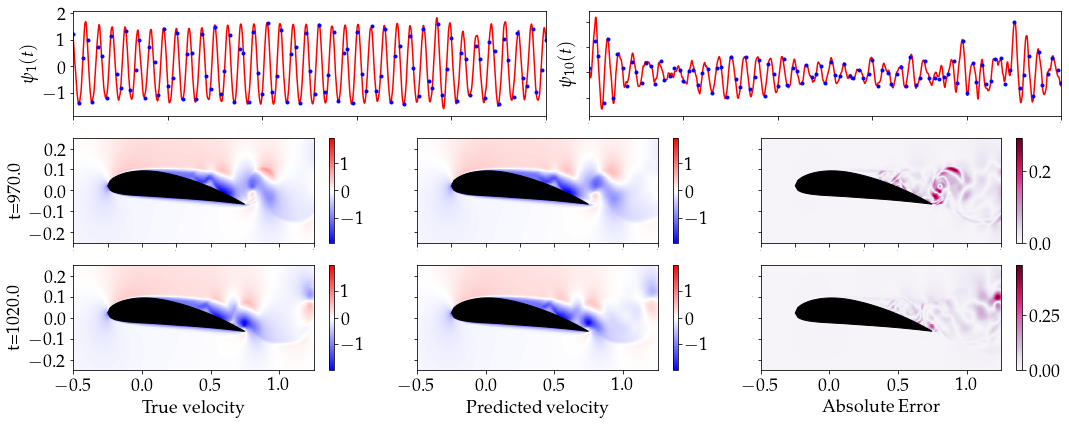

In [7]:
figure(figsize = (15,6))
label_fs = 18

tmin = 975
tmax = 1000

nx = 500
ny = 250

x = np.linspace(-0.5,1.25,nx)
y = np.linspace(-0.25,0.25,ny)
XX, YY = np.meshgrid(x, y)

snapshot_nums = [3800, 4000]
fine_snapshot_nums = [96793, 101793]
snapshot_times = t_POD[snapshot_nums]

rowspan_psi = 4
rowspan_u = 4
n_rows = rowspan_psi + 2*rowspan_u

################################################################################
################################################################################
################################################################################

subplot2grid((n_rows,6),(0,0),rowspan=rowspan_psi,colspan=3)
ind = 0
plot(t,Psi_hat[:,ind], 'r')
plot(t_POD,Psi[:,ind], 'b.')
xlim([tmin,tmax])
ylabel(r'$\psi_{1}(t)$', fontsize = label_fs)
yticks(fontsize = label_fs)
xticks(fontsize = 0)

############################

subplot2grid((n_rows,6),(0,3),rowspan=rowspan_psi,colspan=3)
ind = 9
plot(t,Psi_hat[:,ind], 'r', label=r'$\hat{\psi}(t)$')
plot(t_POD,Psi[:,ind], 'b.', label=r'$\psi(t)$')
xlim([tmin,tmax])
ylabel(r'$\psi_{10}(t)$', fontsize = label_fs)
yticks(fontsize = 0)
xticks(fontsize = 0)

################################################################################
################################################################################
################################################################################

u_hat = reconstruct(Psi_hat[fine_snapshot_nums[0],:])
u = np.load('../../../Re_17500/numpy_files/vel{0:05d}.npy'.format(snapshot_nums[0]+80))
u_grid = interp(u[:,0]-1, X[:,0], X[:,1], XX, YY, method='linear').reshape(ny,nx)
u_hat_grid = interp(u_hat[:,0]-1, X[:,0], X[:,1], XX, YY, method='linear').reshape(ny,nx)
max_abs = np.max(np.abs(np.stack([u_grid,u_hat_grid])))

subplot2grid((n_rows,6),(rowspan_psi,0),rowspan=rowspan_u,colspan=2)
pcolor(XX,YY,u_grid, cmap='bwr', vmin=-max_abs, vmax=max_abs, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = label_fs)
ylabel('t='+str(snapshot_times[0]), fontsize = label_fs)
# title('True velocity', fontsize = label_fs)
xticks(fontsize = 0)

subplot2grid((n_rows,6),(rowspan_psi,2),rowspan=rowspan_u,colspan=2)
pcolor(XX,YY,u_hat_grid, cmap='bwr', vmin=-max_abs, vmax=max_abs, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = 0)
xticks(fontsize = 0)
# title('Predicted velocity', fontsize = label_fs)

subplot2grid((n_rows,6),(rowspan_psi,4),rowspan=rowspan_u,colspan=2)
max_err = np.max(np.abs(u_grid-u_hat_grid))
pcolor(XX,YY,np.abs(u_grid-u_hat_grid), cmap='PuRd', vmin=0, vmax=max_err, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = 0)
# title('Absolute Error', fontsize = label_fs)
xticks(fontsize = 0)

############################

u_hat = reconstruct(Psi_hat[fine_snapshot_nums[1],:])
u = np.load('../../../Re_17500/numpy_files/vel{0:05d}.npy'.format(snapshot_nums[1]+80))
u_grid = interp(u[:,0]-1, X[:,0], X[:,1], XX, YY, method='linear').reshape(ny,nx)
u_hat_grid = interp(u_hat[:,0]-1, X[:,0], X[:,1], XX, YY, method='linear').reshape(ny,nx)
max_abs = np.max(np.abs(np.stack([u_grid,u_hat_grid])))

subplot2grid((n_rows,6),(rowspan_psi+rowspan_u,0),rowspan=rowspan_u,colspan=2)
pcolor(XX,YY,u_grid, cmap='bwr', vmin=-max_abs, vmax=max_abs, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = label_fs)
ylabel('t='+str(snapshot_times[1]), fontsize = label_fs)
xticks([-0.5,0,0.5,1], fontsize = label_fs)
xlabel('True velocity', fontsize = label_fs)

subplot2grid((n_rows,6),(rowspan_psi+rowspan_u,2),rowspan=rowspan_u,colspan=2)
pcolor(XX,YY,u_hat_grid, cmap='bwr', vmin=-max_abs, vmax=max_abs, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = 0)
xticks([-0.5,0,0.5,1], fontsize = label_fs)
xlabel('Predicted velocity', fontsize = label_fs)

subplot2grid((n_rows,6),(rowspan_psi+rowspan_u,4),rowspan=rowspan_u,colspan=2)
max_err = np.max(np.abs(u_grid-u_hat_grid))
pcolor(XX,YY,np.abs(u_grid-u_hat_grid), cmap='PuRd', vmin=0, vmax=max_err, shading='auto')
fill(wing_boundary_x, wing_boundary_y, c='k')
xlim([np.min(x),np.max(x)])
ylim([np.min(y),np.max(y)])
cbar = colorbar()
cbar.ax.tick_params(labelsize=label_fs)
yticks(fontsize = 0)
xticks([-0.5,0,0.5,1], fontsize = label_fs)
xlabel('Absolute Error', fontsize = label_fs)

tight_layout()